# Model + noise + downsampling workflow

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pyleoclim as pyleo

In [2]:
import paleobeasts as pb

from paleobeasts.signal_models import g24
from paleobeasts.utils import resample,noise

### First step : Initializing and integrating the model

See the Ganopolski2024_demo notebook for details.

In [3]:
# Define the forcing
g24_forcing = pb.Forcing(
    g24.calc_f, # initialize the forcing with calc_f
    params = {
        'A':25, # Magnitude of forcing in Wm−2
        'eps':0.5 # nondimensional magnitude of eccentricity modulation
    }
)

# Initialize the model
model3 = g24.Model3(
    forcing=g24_forcing, 
    var_name='ice volume', 
    vc=1.47, #critical ice volume
    f1=-16, #insolation threshold for glacial inception
    f2=16, #insolation threshold for deglaciation inception
    t1=30, #relaxation timescale for glacial inception
    t2=10, #relaxation timescale for deglaciation
)

# Integrate the model
model3.integrate(
    method='euler', # integration method
    t_span=(0, 1200), #start time and end time
    y0=[0, 1], #initial ice volume and state
    kwargs={'dt':1} #timestep
)

/Users/alexjames/GitHub/PaleoBeasts/paleobeasts/signal_models/g24.py:163: RuntimeWarning: invalid value encountered in sqrt
  return 1 + np.sqrt((self.f2 - f) / (self.f2 - self.f1))
/Users/alexjames/GitHub/PaleoBeasts/paleobeasts/signal_models/g24.py:180: RuntimeWarning: invalid value encountered in sqrt
  return 1 - np.sqrt((self.f2 - f) / (self.f2 - self.f1))


Create a basic pyleoclim Series object from the model. Time name and units are arbitrary here (for our purposes anyway).

In [5]:
model_series = model3.to_pyleo(var_names='v')

model_series.label='Signal'
model_series.time_name = 'Age'
model_series.time_unit='ka'

(<Figure size 1000x400 with 1 Axes>, <Axes: xlabel='Age [ka]', ylabel='v'>)

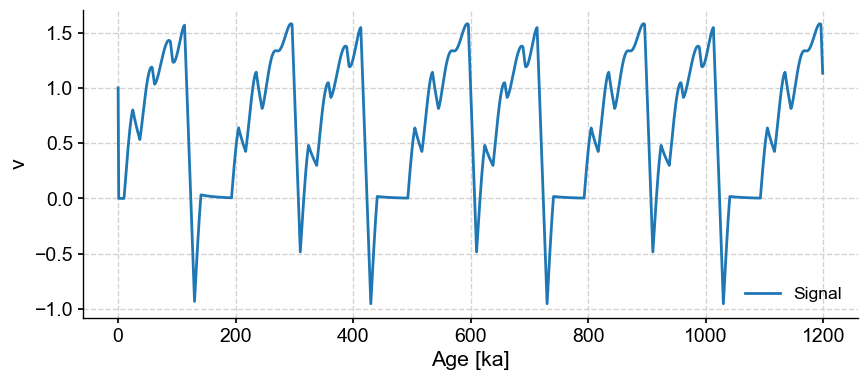

In [6]:
model_series.plot()

Looks good, now lets add some AR(1) noise:

In [7]:
noise_series = model_series.copy()

noise = noise.from_param(
    method='uar1',
    noise_param=[5,1],
    time_pattern='specified',
    settings={'time':noise_series.time},
    scale = .2
)

noise_series.value += noise.value
noise_series.label='Signal + Noise'

(<Figure size 1000x400 with 1 Axes>, <Axes: xlabel='Age [ka]', ylabel='v'>)

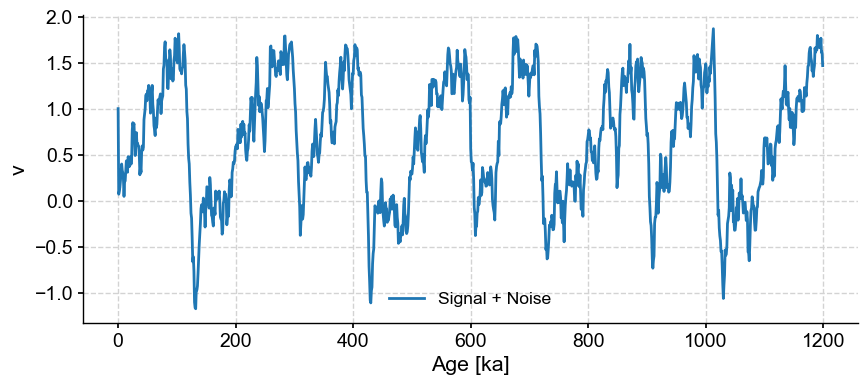

In [8]:
noise_series.plot()

We can go ahead and downsample a bit too:

In [9]:
#Downsampling the data series using the default parameters (method='exponential' and param=1)
downsampled_series = resample.downsample(noise_series,seed=42,method='poisson',param=[.3])
downsampled_series.label = 'Downsampled Signal + Noise'

(<Figure size 1000x400 with 1 Axes>, <Axes: xlabel='Age [ka]', ylabel='v'>)

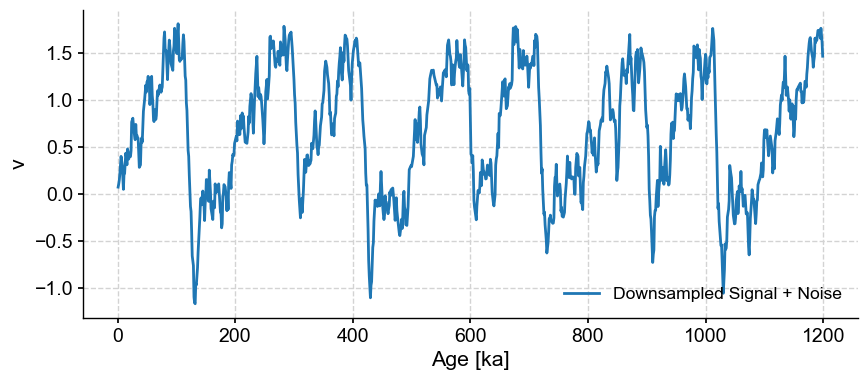

In [10]:
downsampled_series.plot()

We can plot all of these on the same axis to get a better sense as to how things are transforming:

<Axes: xlabel='Age [ka]', ylabel='v'>

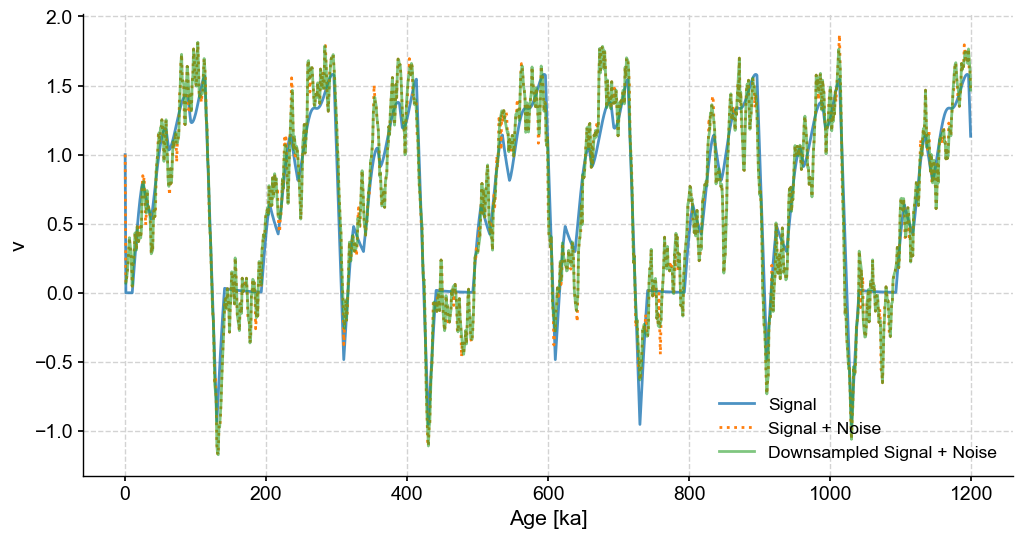

In [11]:
fig,ax = plt.subplots(figsize=(12,6))

model_series.plot(ax=ax,label = 'Signal',alpha=.8)
noise_series.plot(ax=ax,linestyle=':',label='Signal + Noise')
downsampled_series.plot(ax=ax,label='Downsampled Signal + Noise',alpha=.6)

Pyleoclim makes it easy to export to CSV as well via `.to_csv`:

In [12]:
ms = model_series & noise_series & downsampled_series
ms = ms.common_time()

ms.to_csv('./data/model_data.csv')

The two series have different lengths, left: 1200 vs right: 957
Metadata are different:
label property -- left: Signal, right: Downsampled Signal + Noise
The two series have different lengths, left: 1200 vs right: 957
Metadata are different:
label property -- left: Signal + Noise, right: Downsampled Signal + Noise


Feel free to play around further!